# Import libraries

In [1]:
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from eli5 import show_weights, show_prediction
import seaborn as sns
from sklearn.manifold import TSNE
import os
import pandas as pd
from skbio import Protein
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna, generic_protein

#custom
from py.helper import DataProcessing
from py.ml_metrics import evaluate_model, multiclass_logloss
from py.plotting import plot_tsne


/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
# set K-mer length here
kmer = 2


In [3]:
rvdb14 = DataProcessing('RVDB14_complete_coronavirus_fixed.fasta', 'RVDB14_Coronavirus_meta_data_human_pathogen.csv')

# Load cleaned data

In [4]:
cleaned_path = os.path.join(rvdb14.data_path, 'RVDB14_complete_coronavirus_fixed.fasta.csv')

cleaned_df = pd.read_csv(cleaned_path, dtype={'label':int})
# remove nans
cleaned_df.dropna(inplace=True)

# remove artifacts
for index, row in cleaned_df.iterrows():
    if row['label'] < 0:
        cleaned_df.drop(index, inplace=True)
cleanded_df = cleaned_df[cleaned_df['label'] >= 0]
cleaned_df.head()

,seq,id,description,label,accession
0,ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAA...,acc|REFSEQ|NC_030292.1|Ferret,acc|REFSEQ|NC_030292.1|Ferret coronavirus isol...,0,NC_030292.1
1,ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGA...,acc|REFSEQ|NC_028752.1|Camel,acc|REFSEQ|NC_028752.1|Camel alphacoronavirus ...,1,NC_028752.1
2,AGTAAAGTGAGTGTAGCGTGGCTATATCTCTTCTTTTACTTTAACT...,acc|REFSEQ|NC_028806.1|Swine,acc|REFSEQ|NC_028806.1|Swine enteric coronavir...,1,NC_028806.1
3,AAGTGTCGTGCTCCTAGGGGTTGCACTTGACGTGTTCCGTCACGTA...,"acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012,","acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012, a...",0,NC_028824.1
4,GGCCCCCATGGCTAGCAACCGTATTTCGTTGGCTTTTGCCAATGAT...,"acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013,","acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013, ...",1,NC_028814.1


Labels found: [0 1]


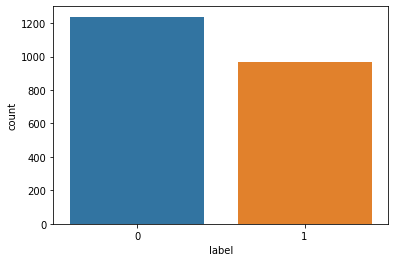

In [5]:
# biinary labels - sanity check 

print(f"Labels found: {cleaned_df['label'].unique()}")
sns.countplot(cleaned_df['label'])

In [6]:
# min and max length of sequences
max_len = max(len(s) for s in cleaned_df['seq'])
min_len =min(len(s) for s in cleaned_df['seq'])
print(f"Sequence length - max:{max_len}, min:{min_len}")

Sequence length - max:31775, min:25320


In [7]:
my_dna = Seq("TTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTA", generic_dna).translate()
for i in Protein(str(my_dna)).iter_kmers(4):
    print(i)

FKDK
KDK*
DK*V
K*V*
*V*R
V*RS
*RSC
RSCL


In [8]:
#make kmers
def get_kmer(row, k):
    my_protein = str(Seq(row, generic_dna).translate())
    return [my_protein[i:i+k] for i in range(0, len(my_protein), k)]


cleaned_df['kmers'] = cleaned_df['seq'].apply(get_kmer, args=(kmer,))
cleaned_df.head()

/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


,seq,id,description,label,accession,kmers
0,ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAA...,acc|REFSEQ|NC_030292.1|Ferret,acc|REFSEQ|NC_030292.1|Ferret coronavirus isol...,0,NC_030292.1,"[TF, KD, K*, V*, RS, CL, LS, LT, *L, *V, KS, T..."
1,ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGA...,acc|REFSEQ|NC_028752.1|Camel,acc|REFSEQ|NC_028752.1|Camel alphacoronavirus ...,1,NC_028752.1,"[T*, VS, YL, SI, DR, KV, AF, *T, LC, LL, FS, T..."
2,AGTAAAGTGAGTGTAGCGTGGCTATATCTCTTCTTTTACTTTAACT...,acc|REFSEQ|NC_028806.1|Swine,acc|REFSEQ|NC_028806.1|Swine enteric coronavir...,1,NC_028806.1,"[SK, VS, VA, WL, YL, FF, YF, N*, LC, AR, FC, L..."
3,AAGTGTCGTGCTCCTAGGGGTTGCACTTGACGTGTTCCGTCACGTA...,"acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012,","acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012, a...",0,NC_028824.1,"[KC, RA, PR, GC, T*, RV, PS, RT, CV, LS, GP, T..."
4,GGCCCCCATGGCTAGCAACCGTATTTCGTTGGCTTTTGCCAATGAT...,"acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013,","acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013, ...",1,NC_028814.1,"[GP, HG, *Q, PY, FV, GF, CQ, *F, RD, FS, SW, L..."


In [9]:
# find letter representations
kmers = []
[kmers.extend(i) for i in  cleaned_df['kmers']]
min_len = min([len(i) for i in cleaned_df['kmers']])
len_kmers = len(set(kmers)) # unique kmers
print(f'Number of unique kmers:{len_kmers}, min length of kmer arr: {min_len}')
# sns.countplot(kmers)

Number of unique kmers:535, min length of kmer arr: 4220


# deep learning with convolutional neural nets
# kmers


In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array
import itertools

# The LabelEncoder encodes a sequence of residues as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')

#fit one-hot encorder with all neucleotides
integer_cat_arr = np.array(list(range(len_kmers))).reshape(-1, 1)
one_hot_encoder = one_hot_encoder.fit(integer_cat_arr)
sequences = [i[:min_len] for i in cleaned_df['kmers']]

#fit the label encoder with all the nucleotides
integer_encoder = integer_encoder.fit(list(itertools.chain.from_iterable(sequences)))
input_features = []
# int_encoded = [] # for LSTM

for sequence in sequences:
  integer_encoded = integer_encoder.transform(sequence)
#   int_encoded.append(integer_encoded)
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

# int_encoded = array(int_encoded)
# print(int_encoded)
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('nucleotude Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
nucleotude Sequence #1:
 ['TF', 'KD', 'K*', 'V*', 'RS', 'CL', 'LS', 'LT', '*L', '*V'] ... ['*L', '*L', 'YY', 'FL', '*H', 'YL', 'IL', 'LG', 'CA', 'RL']
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(cleaned_df['label']).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)
input_labels.shape

Labels:
 [[0 1 1 ... 1 0 0]]
One-hot encoded labels:
 [[1. 0. 0. ... 0. 1. 1.]
 [0. 1. 1. ... 1. 0. 0.]]


(2206, 2)

In [12]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.2, random_state=42)

In [13]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4,input_shape=(train_features.shape[1], len_kmers)))

model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.1))
model.add(Conv1D(filters=32, kernel_size=4))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=3))


model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4217, 32)          68512     
_________________________________________________________________
dropout (Dropout)            (None, 4217, 32)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1405, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1405, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1402, 32)          4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1402, 32)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 467, 32)           0

In [15]:
input_features = None

In [ ]:
history = model.fit(train_features, train_labels, epochs=50, verbose=2, validation_split=0.2, shuffle=True)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Train on 1411 samples, validate on 353 samples
Epoch 1/50
1411/1411 - 600s - loss: 0.6615 - binary_accuracy: 0.6031 - val_loss: 0.6249 - val_binary_accuracy: 0.6771
Epoch 2/50
1411/1411 - 491s - loss: 0.6298 - binary_accuracy: 0.6619 - val_loss: 0.6163 - val_binary_accuracy: 0.6487
Epoch 3/50


In [ ]:
model.save('model.model')

In [ ]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
tf.__version__

In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
import tensorflow.keras.backend as K

def compute_salient_residues(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)

In [ ]:
sequence_index = 2  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_residues(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C') for i in range(2, 6)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Amino Acids')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for residues in one of the positive sequences'
          ' (green indicates the actual residue in motif)');
plt.show()